# Tea Leaf Disease Detection

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
import pathlib

#Run Time: ~20 seconds

In [6]:
path="/Users/annacapels/Desktop/DS Projects/Tea/tea sickness dataset"
directory=pathlib.Path(path)

Getting the names, number of classes, and number of images within individual classes

In [7]:
classlist=[]
for num in os.walk(path):
    subdirectory=num[0]
    lis=str(subdirectory).split('/')
    if(len(lis)>4):
        cls=(lis[len(lis)-1])
        classlist.append(cls)
classlist.pop(0)
num_classes=len(classlist)

print(len(classlist))

print(classlist)

print('\n')
for cls in classlist:
    cnt=len(list(directory.glob(f'{cls}/*.jpg')))
    print(f"Number of images in {cls}: is",cnt)

8
['white spot', 'Anthracnose', 'healthy', 'gray light', 'bird eye spot', 'algal leaf', 'brown blight', 'red leaf spot']


Number of images in white spot: is 142
Number of images in Anthracnose: is 100
Number of images in healthy: is 74
Number of images in gray light: is 100
Number of images in bird eye spot: is 100
Number of images in algal leaf: is 113
Number of images in brown blight: is 113
Number of images in red leaf spot: is 143


Setting Some Parameters 

In [8]:
train=128
test=128
height=224
width=224
split=0.2

Loading training data

In [9]:
train_dataset= tf.keras.utils.image_dataset_from_directory(directory,validation_split=split,subset="training",
seed=123,image_size=(height,width),batch_size=train, class_names=['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot'])

Found 885 files belonging to 8 classes.
Using 708 files for training.


Loading testing data

In [10]:
test_dataset=tf.keras.utils.image_dataset_from_directory(directory,validation_split=split,subset="validation",                                                     
seed=123,image_size=(height,width),batch_size=test, class_names=['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot'])

Found 885 files belonging to 8 classes.


Using 177 files for validation.


Displaying Sample Dataset

Note: indices start at 1

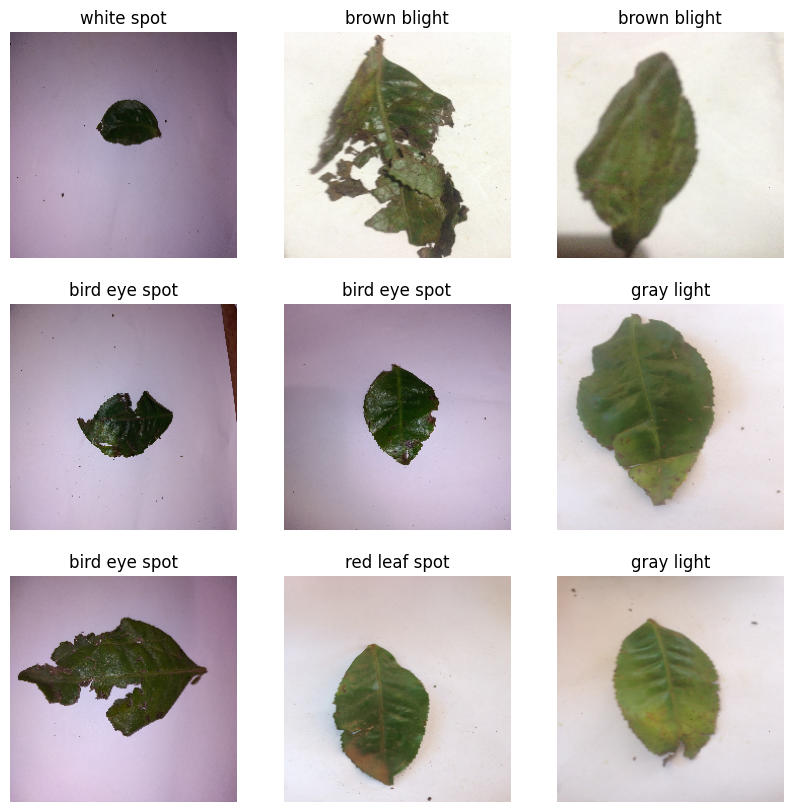

In [11]:
plt.figure(figsize=(10,10))
for image,label in train_dataset.take(1):
    for x in range(9):
        y=plt.subplot(3,3,x+1)
        plt.imshow(image[x].numpy().astype("uint8"))
        plt.title(classlist[label[x]])
        plt.axis("off")

#Run Time: ~13 seconds

# Preporcessing and Data Augmentation 

Note: Caching datasets helps: 
1. Avoid unnecessary reprocessing
2. Randomize (and in turn reducing bias)
3. Improves efficiency during training

In [12]:
train_datset=train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

aug=keras.Sequential([layers.RandomFlip("horizontal",input_shape=(height,width,3)),layers.RandomFlip("vertical"),
layers.RandomRotation(0.2),layers.RandomZoom(0.2),])

## Model Architecture - Convolutional Neural Network (CNN)

CNN are usually best used for image classification, which is what was needed in this project.

Keras Sequential API was used as it allows for stacking of multiple layers sequentially. 

The layers are as follows: 
1. Rescaling input pixel values (1/255) which makes sure pixel values in range of 0-1
2. Adding a 2D convolutional layer with 16 filters (size of 3x3), pads to make sure maps have same spatial dimesnions as input, relu adds non-linearity to model
3. Similar to step 2 except just adding different parameters to get higher - lvel features from images thorugh convolutions and downsampling
4. Same as 3 
5. Same as 3 
6. Same as 3
7. Same as 3
8. Flattens multi-dimensional output into a 1D vector (essentially makes spatialally arranged features into a linear format)
9. Adds a dense (fully connected) layer with 32 units and relu. 
    - Desnse layer connects each input neuron to every output neuron
10. Introduce regularization (to help prevent overfitting) by adding dropout layer that makes some input units to 0 
11. Layer to help model to learn complex patterns and reduce overfiting 
12. Predict the probability distribution over classes during training and inference. 

In [13]:
model=Sequential([
    aug,
    layers.Rescaling(1/255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])

# Compiling and Displaying the Model

In [14]:
alpha=0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                 

# Running Model

In [15]:
history=model.fit(train_dataset,validation_data=test_dataset,epochs=320,verbose=0)
# Run Time: ~75 minutes
#2nd run time ~55 min w/ the stratified sampling 
# Really taking a toll on the cpu it sounds like an airplane lifiting off
#Run when plugged in...takes too much battery to do it at school 

# Comparing Training and Testing Accuracy and Loss

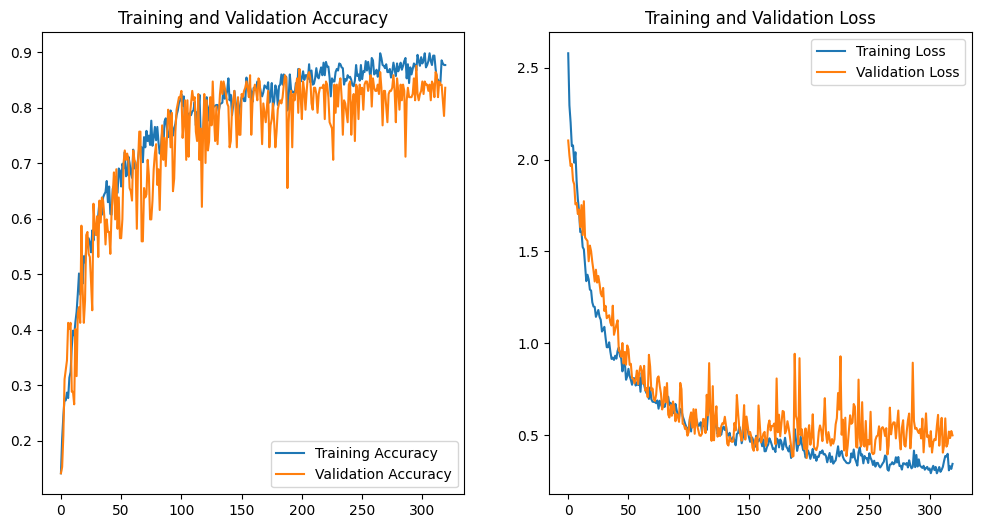

In [16]:
accuracy=history.history['accuracy']
validation_accuracy= history.history['val_accuracy']
loss=history.history['loss']
validation_loss = history.history['val_loss']

epochs_range= range(320)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs_range,accuracy,label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction

Predictions:
 [7 7 0 7 2 7 2 1 1 4 4 3 7 6 0 1 0 3 3 4 3 0 6 3 7 4 1 1 4 4 3 5 3 0 6 4 3
 1 4 4 7 7 6 4 0 4 6 3 1 3 6 2 3 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 4
 2 7 1 3 2 4 2 6 6 0 0 1 1 4 7 0 0 4 5 7 2 6 4 7 7 7 2 6 0 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 7 4 4 1 3 4]
Labels:
 [3 7 2 7 0 7 2 1 1 4 0 7 7 6 0 1 2 3 3 4 3 0 6 3 7 4 1 1 0 4 7 5 3 0 6 4 3
 7 4 4 7 7 6 2 0 4 6 3 1 3 6 2 7 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 2
 2 7 1 3 2 0 4 6 6 0 0 1 1 4 7 0 0 4 5 3 2 6 4 7 7 3 2 6 0 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 3 0 4 7 3 0]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.67      0.75        18
           1       0.87      1.00      0.93        13
           2       0.78      0.64      0.70        11
           3       0.86      0.83      0.84        23
           4       0.73      0.95      0.83        20
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        1

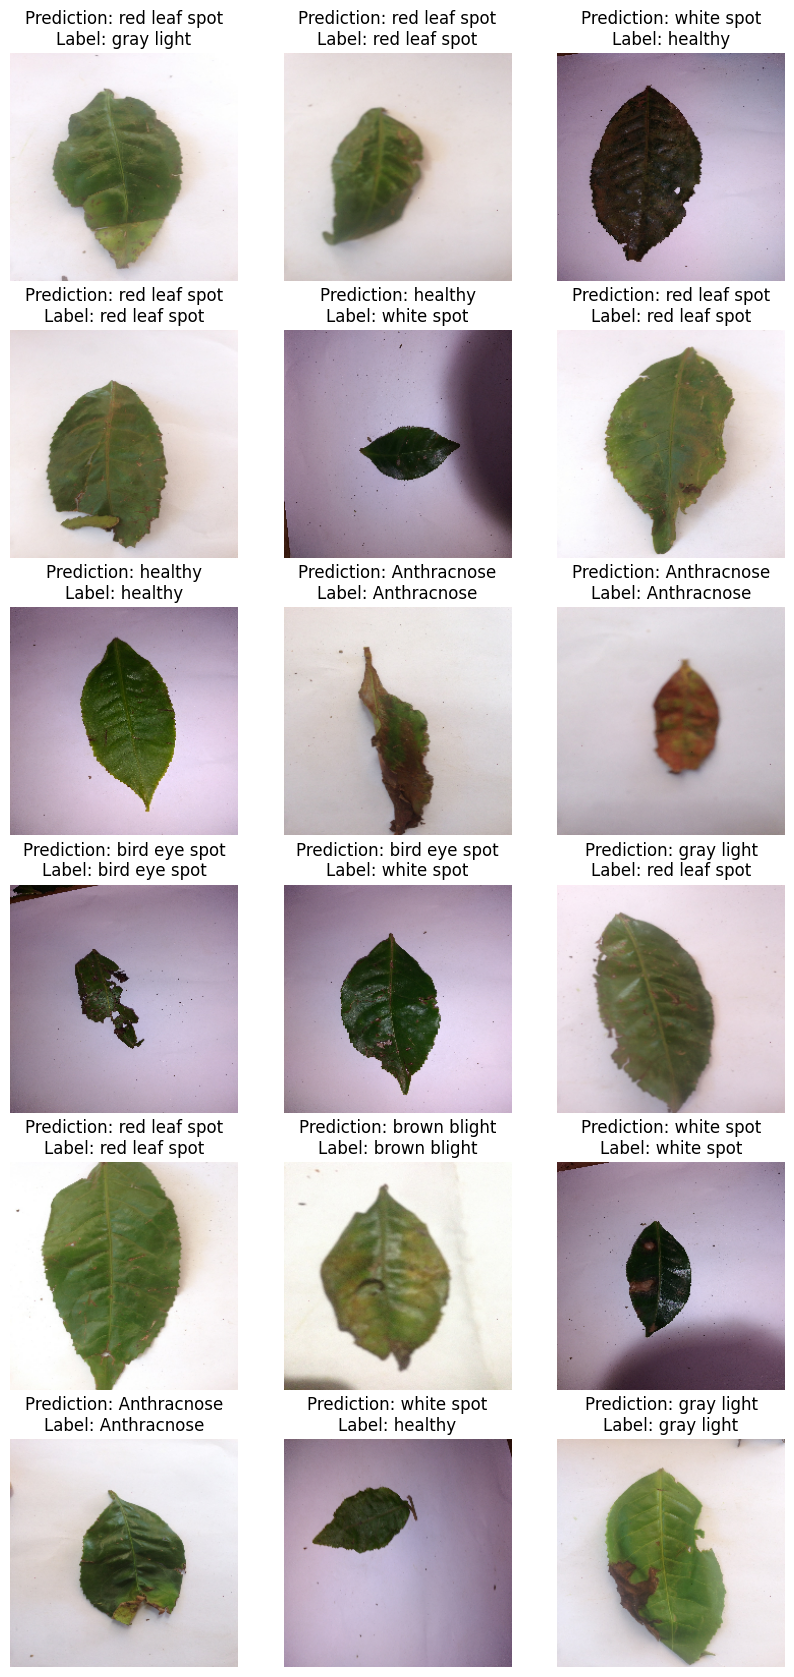

In [17]:

imgbatch, labelbatch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(imgbatch)
predictions_list = []
for x in predictions:
    p = np.argmax(x)
    predictions_list.append(p)

predictions_list = np.array(predictions_list)
print('Predictions:\n', predictions_list)
print('Labels:\n', labelbatch)

#Classification report
report = classification_report(labelbatch, predictions_list)
print('Classification Report:\n', report)

#Displaying images with predictions and labels
plt.figure(figsize=(10, 21))
for x in range(18):
    xx = plt.subplot(6, 3, x + 1)
    plt.imshow(imgbatch[x].astype("uint8"))
    plt.title("Prediction: " + classlist[predictions_list[x]] + "\nLabel: " + classlist[labelbatch[x]])
    plt.axis("off")

plt.show()

# Accuracy 

In [18]:
hisdf=pd.DataFrame(history.history)
hisdf.to_csv("history.csv")
hisdf.tail()

,loss,accuracy,val_loss,val_accuracy
315,0.399859,0.846045,0.454708,0.841808
316,0.309823,0.885593,0.520487,0.841808
317,0.332231,0.879943,0.485417,0.813559
318,0.317722,0.877119,0.523794,0.785311
319,0.345046,0.877119,0.500182,0.836158


In [19]:
#Confusion matrix
confusion_mat = confusion_matrix(labelbatch, predictions_list)
print('Confusion Matrix:\n', confusion_mat)

Confusion Matrix:
 [[12  0  1  0  5  0  0  0]
 [ 0 13  0  0  0  0  0  0]
 [ 2  0  7  0  2  0  0  0]
 [ 0  0  0 19  0  0  0  4]
 [ 0  0  1  0 19  0  0  0]
 [ 0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 15  0]
 [ 0  2  0  3  0  0  0 16]]
